In [1]:
import pandas as pd
git_blame = pd.read_csv("linux_blame_log.csv")
git_blame.head()

,path,author,timestamp,line
0,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,1
1,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,2
2,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,3
3,drivers/scsi/bfa/bfad_drv.h,Jing Huang,1253753175000000000,4
4,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,5


Wir haben X Einträge. Es wird viel Speicher belegt, wenn wir die Daten roh einlesen

In [2]:
git_blame.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665947 entries, 0 to 5665946
Data columns (total 4 columns):
path         object
author       object
timestamp    int64
line         int64
dtypes: int64(2), object(2)
memory usage: 971.8 MB


Wir können zuerst einmal noch bei den verwendeten Datentypen nachhelfen.

 Categorical == kategoriale Variablen, also Variablen, die nur eine limitierte Anzahl an Werten annehmen können. Werte in den Spalten werden dann zu Referenzen, die auf die eigentlichen Werte zeigen. AKA => Auswertungn werden schneller. Hat bei sehr vielen Daten wie hier viel Sinn.

In [3]:
git_blame.path = pd.Categorical(git_blame.path)
git_blame.author = pd.Categorical(git_blame.author)
git_blame.timestamp = pd.to_datetime(git_blame.timestamp)
git_blame.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665947 entries, 0 to 5665946
Data columns (total 4 columns):
path         category
author       category
timestamp    datetime64[ns]
line         int64
dtypes: category(2), datetime64[ns](1), int64(1)
memory usage: 109.9 MB


Einfach Auswertung dieser Art bringt nichts, müssen unseren Kontext beachten. Linus Torvalds hat den initialen Git-Commit mit dem alten Bestandscode vorgenommen, deshalb ist diese Auswertung nicht korrekt:

In [4]:
git_blame.author.value_counts().head(10)

Linus Torvalds           838200
Hans Verkuil             118432
Mauro Carvalho Chehab    102107
Michael Chan              53945
Mike Marciniszyn          44843
Ralph Campbell            42453
Nicholas Bellinger        41823
Laurent Pinchart          40438
Antti Palosaari           40390
Alexander Duyck           39307
Name: author, dtype: int64

In [5]:
git_blame.head()

,path,author,timestamp,line
0,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,1
1,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,2
2,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,3
3,drivers/scsi/bfa/bfad_drv.h,Jing Huang,2009-09-24 00:46:15,4
4,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,5


Was ist eigentlich Wissen? Unsere Annäherung / Modell: Geänderte Codezeilen im letzten Jahr


In [6]:
a_year_ago = pd.Timestamp("today") - pd.DateOffset(years=1)
a_year_ago

Timestamp('2017-04-19 10:31:08.020478')

In [7]:
(git_blame.timestamp >= a_year_ago).head()

0    False
1    False
2    False
3    False
4    False
Name: timestamp, dtype: bool

In [8]:
git_blame['knowing'] = git_blame.timestamp >= a_year_ago
git_blame.head()

,path,author,timestamp,line,knowing
0,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,1,False
1,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,2,False
2,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,3,False
3,drivers/scsi/bfa/bfad_drv.h,Jing Huang,2009-09-24 00:46:15,4,False
4,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,5,False


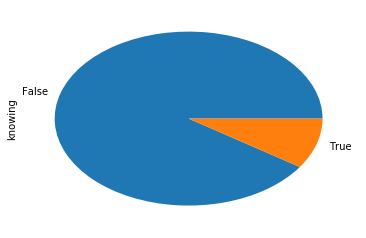

In [9]:
%matplotlib inline
git_blame.knowing.value_counts().plot.pie()

In [10]:
knowledge = git_blame[git_blame.knowing]
knowledge.head()

,path,author,timestamp,line,knowing
316,drivers/scsi/bfa/bfad_drv.h,Kees Cook,2017-10-16 21:43:17,317,True
736,drivers/scsi/bfa/bfad_im.c,Hannes Reinecke,2017-08-25 11:57:03,376,True
739,drivers/scsi/bfa/bfad_im.c,Hannes Reinecke,2017-08-25 11:57:03,379,True
742,drivers/scsi/bfa/bfad_im.c,Hannes Reinecke,2017-08-25 11:57:03,382,True
748,drivers/scsi/bfa/bfad_im.c,Hannes Reinecke,2017-08-25 11:57:03,388,True


In [11]:
knowledge_carrier = knowledge.author.value_counts() / len(knowledge)
knowledge_carrier.head(10)

Anirudh Venkataramanan    0.035256
Daniel Scheller           0.031053
Yasunari Takiguchi        0.024188
Aviad Krawczyk            0.023527
Stanimir Varbanov         0.020557
Salil                     0.019973
Mika Westerberg           0.016489
Todor Tomov               0.015829
Jakub Kicinski            0.015367
Tomer Tayar               0.012628
Name: author, dtype: float64

In [12]:
git_blame.head()

,path,author,timestamp,line,knowing
0,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,1,False
1,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,2,False
2,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,3,False
3,drivers/scsi/bfa/bfad_drv.h,Jing Huang,2009-09-24 00:46:15,4,False
4,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,5,False


Komponenten können aus dem Pfad gewonnen werden

In [13]:
git_blame.path.value_counts().head()

drivers/media/dvb-frontends/drx39xyj/drxj_map.h    15055
drivers/isdn/hardware/eicon/message.c              14954
drivers/net/ethernet/sfc/mcdi_pcol.h               14534
drivers/net/ethernet/intel/i40e/i40e_main.c        14484
drivers/staging/rdma/hfi1/chip.c                   13914
Name: path, dtype: int64

_Split Schritt für Schritt auf bauen_

In [14]:
git_blame['component'] = git_blame.path.str.split("/").str[:2].str.join(":")
git_blame.head()

,path,author,timestamp,line,knowing,component
0,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,1,False,drivers:scsi
1,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,2,False,drivers:scsi
2,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,3,False,drivers:scsi
3,drivers/scsi/bfa/bfad_drv.h,Jing Huang,2009-09-24 00:46:15,4,False,drivers:scsi
4,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,5,False,drivers:scsi


Nun können wir unsere Daten nach den Komponenten gruppieren.

In [15]:
knowledge_per_component = git_blame.groupby('component')[['knowing']].mean()
knowledge_per_component.head()

,knowing
component,
arch:arc,0.000000
arch:arm,0.000588
arch:i386,0.000000
arch:ia64,0.000000
arch:mips,0.000000


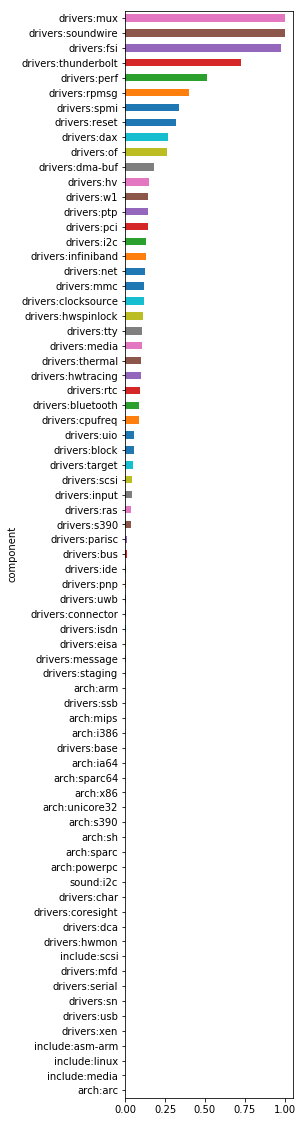

In [16]:
knowledge_per_component.knowing.sort_values().plot.barh(figsize=[3,20])

_Unnützes Wissen: arch:arc -Prozessor steck im SuperFX-Chip von Super Nintentdo Spielemodulen drin. Vielleicht wollte jdm da ja mal Linux drauf laufen lassen..._